In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import warnings
warnings.filterwarnings('ignore')


In [3]:
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


# 1. DATA LOADING AND PREPARATION

print("="*70)
print("OHIO LOW BIRTH WEIGHT ANALYSIS")
print("="*70)

# Load datasets
print("\n1. Loading data...")
birth_path = pd.read_csv(r"C:\Users\kehin\Downloads\OhioBirths.csv")
demographic = pd.read_csv(r"C:\Users\kehin\Downloads\OhioDemographics.csv")

In [11]:
# Display basic information
print(f"\nBirths dataset shape: {birth_path.shape}")
print(f"Demographic dataset shape: {demographic.shape}")
print("\nBirths columns:", birth_path.columns.tolist())
print("Demographic columns:", demographic.columns.tolist())

# Check for missing values
print("\nMissing values in births:")
print(birth_path.isnull().sum())
print("\nMissing values in demographic:")
print(demographic.isnull().sum())


Births dataset shape: (792526, 5)
Demographic dataset shape: (88, 5)

Births columns: ['county_of_birth', 'age_of_mother', 'race_of_mother', 'low_birth_weight', 'birth_id']
Demographic columns: ['Unnamed: 0', 'County', 'Population', 'Below.HS.Education.Percentage', 'Unemployment.Rate']

Missing values in births:
county_of_birth     0
age_of_mother       0
race_of_mother      0
low_birth_weight    0
birth_id            0
dtype: int64

Missing values in demographic:
Unnamed: 0                       0
County                           0
Population                       0
Below.HS.Education.Percentage    0
Unemployment.Rate                0
dtype: int64


## Clean demographic dataset

In [14]:
# Display basic information
print(f"\nBirths dataset shape: {birth_path.shape}")
print(f"Demographic dataset shape: {demographic.shape}")
print("\nBirths columns:", birth_path.columns.tolist())
print("Demographic columns:", demographic.columns.tolist())

# Check for missing values
print("\nMissing values in births:")
print(birth_path.isnull().sum())
print("\nMissing values in demographic:")
print(demographic.isnull().sum())


Births dataset shape: (792526, 5)
Demographic dataset shape: (88, 5)

Births columns: ['county_of_birth', 'age_of_mother', 'race_of_mother', 'low_birth_weight', 'birth_id']
Demographic columns: ['Unnamed: 0', 'County', 'Population', 'Below.HS.Education.Percentage', 'Unemployment.Rate']

Missing values in births:
county_of_birth     0
age_of_mother       0
race_of_mother      0
low_birth_weight    0
birth_id            0
dtype: int64

Missing values in demographic:
Unnamed: 0                       0
County                           0
Population                       0
Below.HS.Education.Percentage    0
Unemployment.Rate                0
dtype: int64


## Clean birth dataset

In [17]:
# Clean Births dataset
birth_path = birth_path.copy()

# Convert age_of_mother to numeric, unknowns -> NaN
birth_path['age_of_mother'] = pd.to_numeric(birth_path['age_of_mother'], errors='coerce')

# Convert race_of_mother to categorical
birth_path['race_of_mother'] = birth_path['race_of_mother'].astype('category')

# Ensure low_birth_weight is numeric 0/1
birth_path['low_birth_weight'] = pd.to_numeric(birth_path['low_birth_weight'], errors='coerce')


## Merge datasets

In [32]:
 # Merge datasets
merged_data = pd.merge(birth_path, demographic, on='county_of_birth', how='left')


In [40]:
numeric_cols = merged_data.select_dtypes(include='number').columns.tolist()
missing_county_data = merged_data[numeric_cols].isna().sum()
print("Missing values in numeric columns:\n", missing_county_data)
# Final inspection
print("Merged dataset shape:", merged_data.shape)
print("Columns:", merged_data.columns)
print("Missing values:\n", merged_data.isna().sum())


Missing values in numeric columns:
 age_of_mother                       24
low_birth_weight                     0
birth_id                             0
Unnamed: 0                       13391
Below.HS.Education.Percentage    13391
Unemployment.Rate                13391
dtype: int64
Merged dataset shape: (792526, 9)
Columns: Index(['county_of_birth', 'age_of_mother', 'race_of_mother',
       'low_birth_weight', 'birth_id', 'Unnamed: 0', 'Population',
       'Below.HS.Education.Percentage', 'Unemployment.Rate'],
      dtype='object')
Missing values:
 county_of_birth                      0
age_of_mother                       24
race_of_mother                       0
low_birth_weight                     0
birth_id                             0
Unnamed: 0                       13391
Population                       13391
Below.HS.Education.Percentage    13391
Unemployment.Rate                13391
dtype: int64


In [42]:
# Strip leading/trailing whitespace and make all lowercase
birth_path['county_of_birth'] = birth_path['county_of_birth'].str.strip().str.lower()
demographic['county_of_birth'] = demographic['county_of_birth'].str.strip().str.lower()

# Merge again
merged_data = pd.merge(birth_path, demographic, on='county_of_birth', how='left')

# Check missing values again
print(merged_data[numeric_cols].isna().sum())


age_of_mother                       24
low_birth_weight                     0
birth_id                             0
Unnamed: 0                       13391
Below.HS.Education.Percentage    13391
Unemployment.Rate                13391
dtype: int64


In [44]:
# Counties in births not in demographics
birth_counties = set(birth_path['county_of_birth'].unique())
demo_counties = set(demographic['county_of_birth'].unique())

mismatched = birth_counties - demo_counties
print("Counties in births not in demographics:", mismatched)


Counties in births not in demographics: {'non-ohio county'}


In [46]:
# Example: replace mismatches
demographic['county_of_birth'] = demographic['county_of_birth'].replace({
    'st. clair': 'saint clair',
    'mc kean': 'mckean',
    # add other fixes here
})
# Example: median imputation
merged_data['age_of_mother'] = merged_data['age_of_mother'].fillna(merged_data['age_of_mother'].median())
merged_data['Below.HS.Education.Percentage'] = merged_data['Below.HS.Education.Percentage'].fillna(merged_data['Below.HS.Education.Percentage'].median())
merged_data['Unemployment.Rate'] = merged_data['Unemployment.Rate'].fillna(merged_data['Unemployment.Rate'].median())
merged_data = pd.merge(birth_path, demographic, on='county_of_birth', how='left')
print(merged_data[['county_of_birth', 'Population', 'Below.HS.Education.Percentage', 'Unemployment.Rate']].isna().sum())

county_of_birth                      0
Population                       13391
Below.HS.Education.Percentage    13391
Unemployment.Rate                13391
dtype: int64


In [48]:
import pandas as pd

# Step 1: Standardize county names
birth_path['county_of_birth'] = birth_path['county_of_birth'].str.strip().str.lower()
demographic['county_of_birth'] = demographic['county_of_birth'].str.strip().str.lower()

# Step 2: Merge datasets
merged_data = pd.merge(birth_path, demographic, on='county_of_birth', how='left')

# Step 3: Check for unmatched counties
birth_counties = set(birth_path['county_of_birth'].unique())
demo_counties = set(demographic['county_of_birth'].unique())
unmatched_counties = birth_counties - demo_counties
print("Counties in births not in demographics:", unmatched_counties)

# Step 4: Check missing values for county-level predictors 
missing_counts = merged_data[['Population', 'Below.HS.Education.Percentage', 'Unemployment.Rate']].isna().sum()
print("\nMissing values after merge:\n", missing_counts)

# Step 5: Impute remaining missing values (median) 
merged_data['Below.HS.Education.Percentage'] = merged_data['Below.HS.Education.Percentage'].fillna(
    merged_data['Below.HS.Education.Percentage'].median()
)
merged_data['Unemployment.Rate'] = merged_data['Unemployment.Rate'].fillna(
    merged_data['Unemployment.Rate'].median()
)

# Step 6: Verify the final dataset 
print("\nMerged dataset shape:", merged_data.shape)
print("Columns:", merged_data.columns)
print("Missing values:\n", merged_data.isna().sum())


Counties in births not in demographics: {'non-ohio county'}

Missing values after merge:
 Population                       13391
Below.HS.Education.Percentage    13391
Unemployment.Rate                13391
dtype: int64

Merged dataset shape: (792526, 9)
Columns: Index(['county_of_birth', 'age_of_mother', 'race_of_mother',
       'low_birth_weight', 'birth_id', 'Unnamed: 0', 'Population',
       'Below.HS.Education.Percentage', 'Unemployment.Rate'],
      dtype='object')
Missing values:
 county_of_birth                      0
age_of_mother                       24
race_of_mother                       0
low_birth_weight                     0
birth_id                             0
Unnamed: 0                       13391
Population                       13391
Below.HS.Education.Percentage        0
Unemployment.Rate                    0
dtype: int64


In [50]:
# Drop or impute age_of_mother missing values
merged_data = merged_data.dropna(subset=['age_of_mother'])

# Optionally drop Population if it’s not usable
merged_data = merged_data.drop(columns=['Population'])

# Convert county_of_birth to categorical for modeling
merged_data['county_of_birth'] = merged_data['county_of_birth'].astype('category')

# Convert race_of_mother to categorical if not already
merged_data['race_of_mother'] = merged_data['race_of_mother'].astype('category')

# Check final cleaned dataset
print("Final dataset shape:", merged_data.shape)
print(merged_data.head())


Final dataset shape: (792502, 8)
  county_of_birth  age_of_mother race_of_mother  low_birth_weight  birth_id  \
0    adams county           31.0          White                 1         1   
1    adams county           31.0          White                 1         2   
2    adams county           31.0          White                 1         3   
3    adams county           31.0          White                 1         4   
4    adams county           31.0          White                 1         5   

   Unnamed: 0  Below.HS.Education.Percentage  Unemployment.Rate  
0         1.0                           14.8                6.5  
1         1.0                           14.8                6.5  
2         1.0                           14.8                6.5  
3         1.0                           14.8                6.5  
4         1.0                           14.8                6.5  


## Descriptive statistics

In [65]:
# DESCRIPTIVE STATISTICS

print("\n" + "="*70)
print("DESCRIPTIVE STATISTICS")
print("="*70)

# Overall LBW rate
overall_lbw = merged_data['low_birth_weight'].mean() * 100
print(f"\nOverall Low Birth Weight Rate: {overall_lbw:.2f}%")
print(f"Total births analyzed: {len(merged_data):,}")

# LBW by age group
print("\n--- LBW Rate by Maternal Age Group ---")
age_summary = merged_data.groupby('age_of_mother').agg({
    'low_birth_weight': ['count', 'mean']
}).round(4)
age_summary.columns = ['N_births', 'LBW_Rate']
age_summary['LBW_Rate_Pct'] = age_summary['LBW_Rate'] * 100
print(age_summary)

# LBW by race
print("\n--- LBW Rate by Race ---")
race_summary = merged_data.groupby('race_of_mother').agg({
    'low_birth_weight': ['count', 'mean']
}).round(4)
race_summary.columns = ['N_births', 'LBW_Rate']
race_summary['LBW_Rate_Pct'] = race_summary['LBW_Rate'] * 100
race_summary['Percentage'] = (race_summary['N_births'] / len(merged_data) * 100).round(1)
race_summary = race_summary.sort_values('LBW_Rate_Pct', ascending=False)
print(race_summary)

# County-level summary
print("\n--- County-Level Summary ---")
county_summary = merged_data.groupby('county_of_birth').agg({
    'low_birth_weight': ['count', 'mean'],
    'Below.HS.Education.Percentage': 'first',
    'Unemployment.Rate': 'first',
}).round(4)

county_summary.columns = ['N_births', 'LBW_Rate', 'Below_HS_Pct', 
                          'Unemployment_Rate']   
county_summary['LBW_Rate_Pct'] = county_summary['LBW_Rate'] * 100
county_summary = county_summary.sort_values('LBW_Rate_Pct', ascending=False)

print(f"\nNumber of counties: {len(county_summary)}")
print(f"LBW rate range: {county_summary['LBW_Rate_Pct'].min():.2f}% to {county_summary['LBW_Rate_Pct'].max():.2f}%")
print("\nTop 5 counties with highest LBW rates:")
print(county_summary.head()[['N_births', 'LBW_Rate_Pct', 'Below_HS_Pct', 'Unemployment_Rate']])
print("\nTop 5 counties with lowest LBW rates:")
print(county_summary.tail()[['N_births', 'LBW_Rate_Pct', 'Below_HS_Pct', 'Unemployment_Rate']])



DESCRIPTIVE STATISTICS

Overall Low Birth Weight Rate: 78.78%
Total births analyzed: 792,502

--- LBW Rate by Maternal Age Group ---
               N_births  LBW_Rate  LBW_Rate_Pct
age_of_mother                                  
12.0                 19    1.0000        100.00
13.0                199    0.8643         86.43
14.0               1511    0.8855         88.55
15.0               5632    0.8960         89.60
16.0              12332    0.8968         89.68
17.0              17780    0.8544         85.44
18.0              26885    0.8159         81.59
19.0              35704    0.7838         78.38
20.0              39599    0.7730         77.30
21.0              39362    0.7626         76.26
22.0              37411    0.7647         76.47
23.0              36943    0.7604         76.04
24.0              36930    0.7575         75.75
25.0              37763    0.7586         75.86
26.0              38879    0.7660         76.60
27.0              40577    0.7733         77.33
28

## Descriptive plots

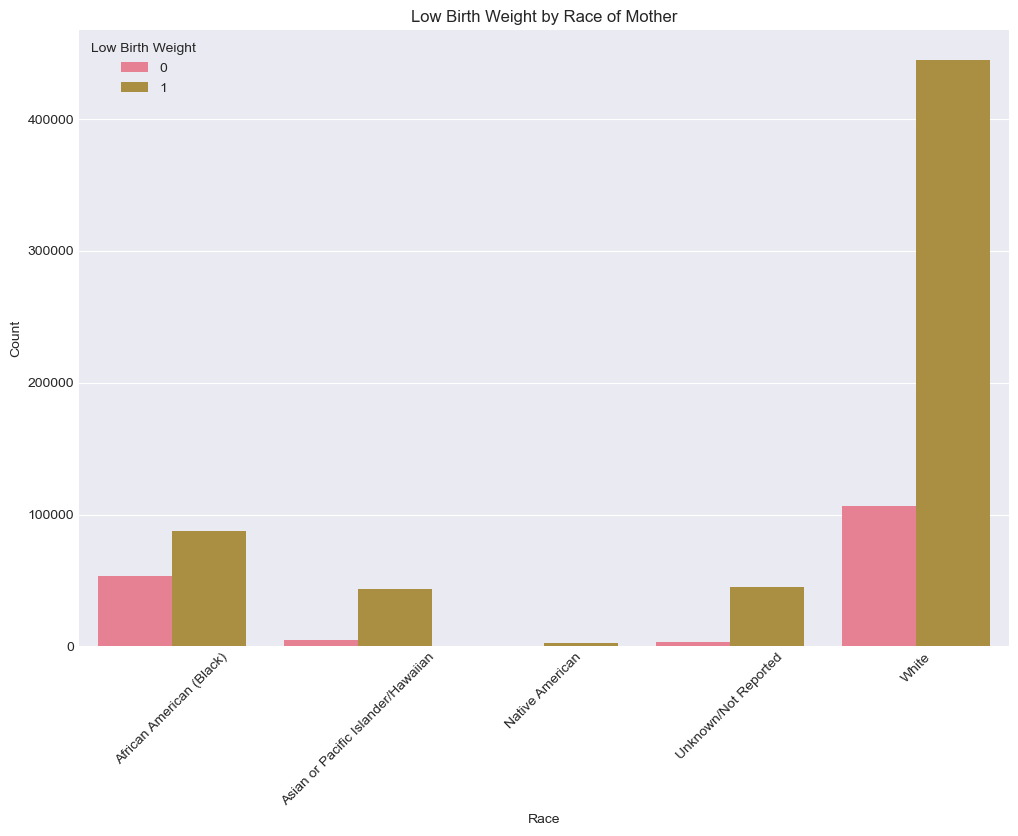

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=merged_data, x='race_of_mother', hue='low_birth_weight')
plt.title("Low Birth Weight by Race of Mother")
plt.xlabel("Race")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Low Birth Weight")
plt.show()


## Age Distribution

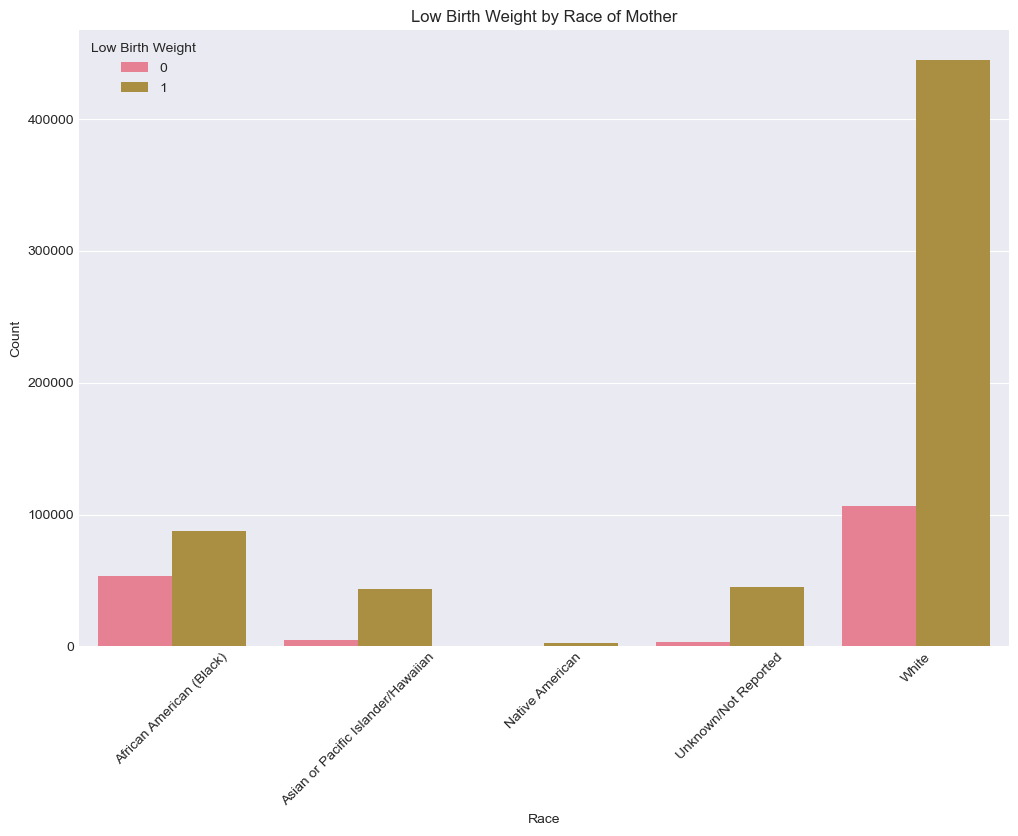

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=merged_data, x='race_of_mother', hue='low_birth_weight')
plt.title("Low Birth Weight by Race of Mother")
plt.xlabel("Race")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Low Birth Weight")
plt.show()


## Education/unemployment vs lbw (scatter + regression)

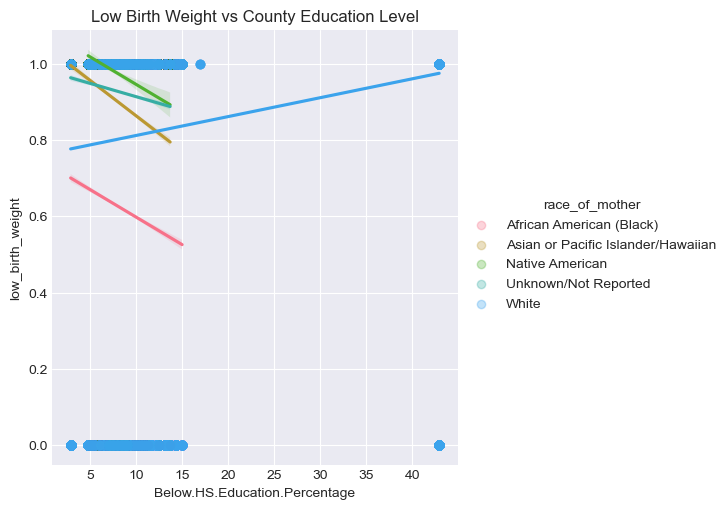

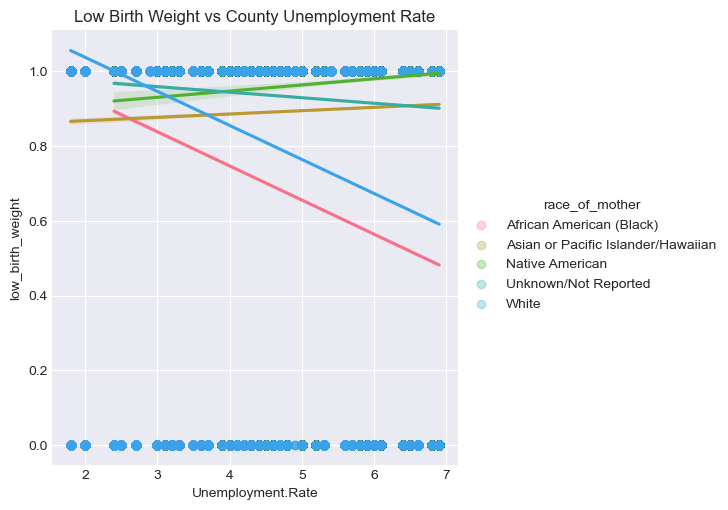

In [74]:
sns.lmplot(data=merged_data, x='Below.HS.Education.Percentage', y='low_birth_weight', hue='race_of_mother', scatter_kws={'alpha':0.3})
plt.title("Low Birth Weight vs County Education Level")
plt.show()

sns.lmplot(data=merged_data, x='Unemployment.Rate', y='low_birth_weight', hue='race_of_mother', scatter_kws={'alpha':0.3})
plt.title("Low Birth Weight vs County Unemployment Rate")
plt.show()

## County level summaries

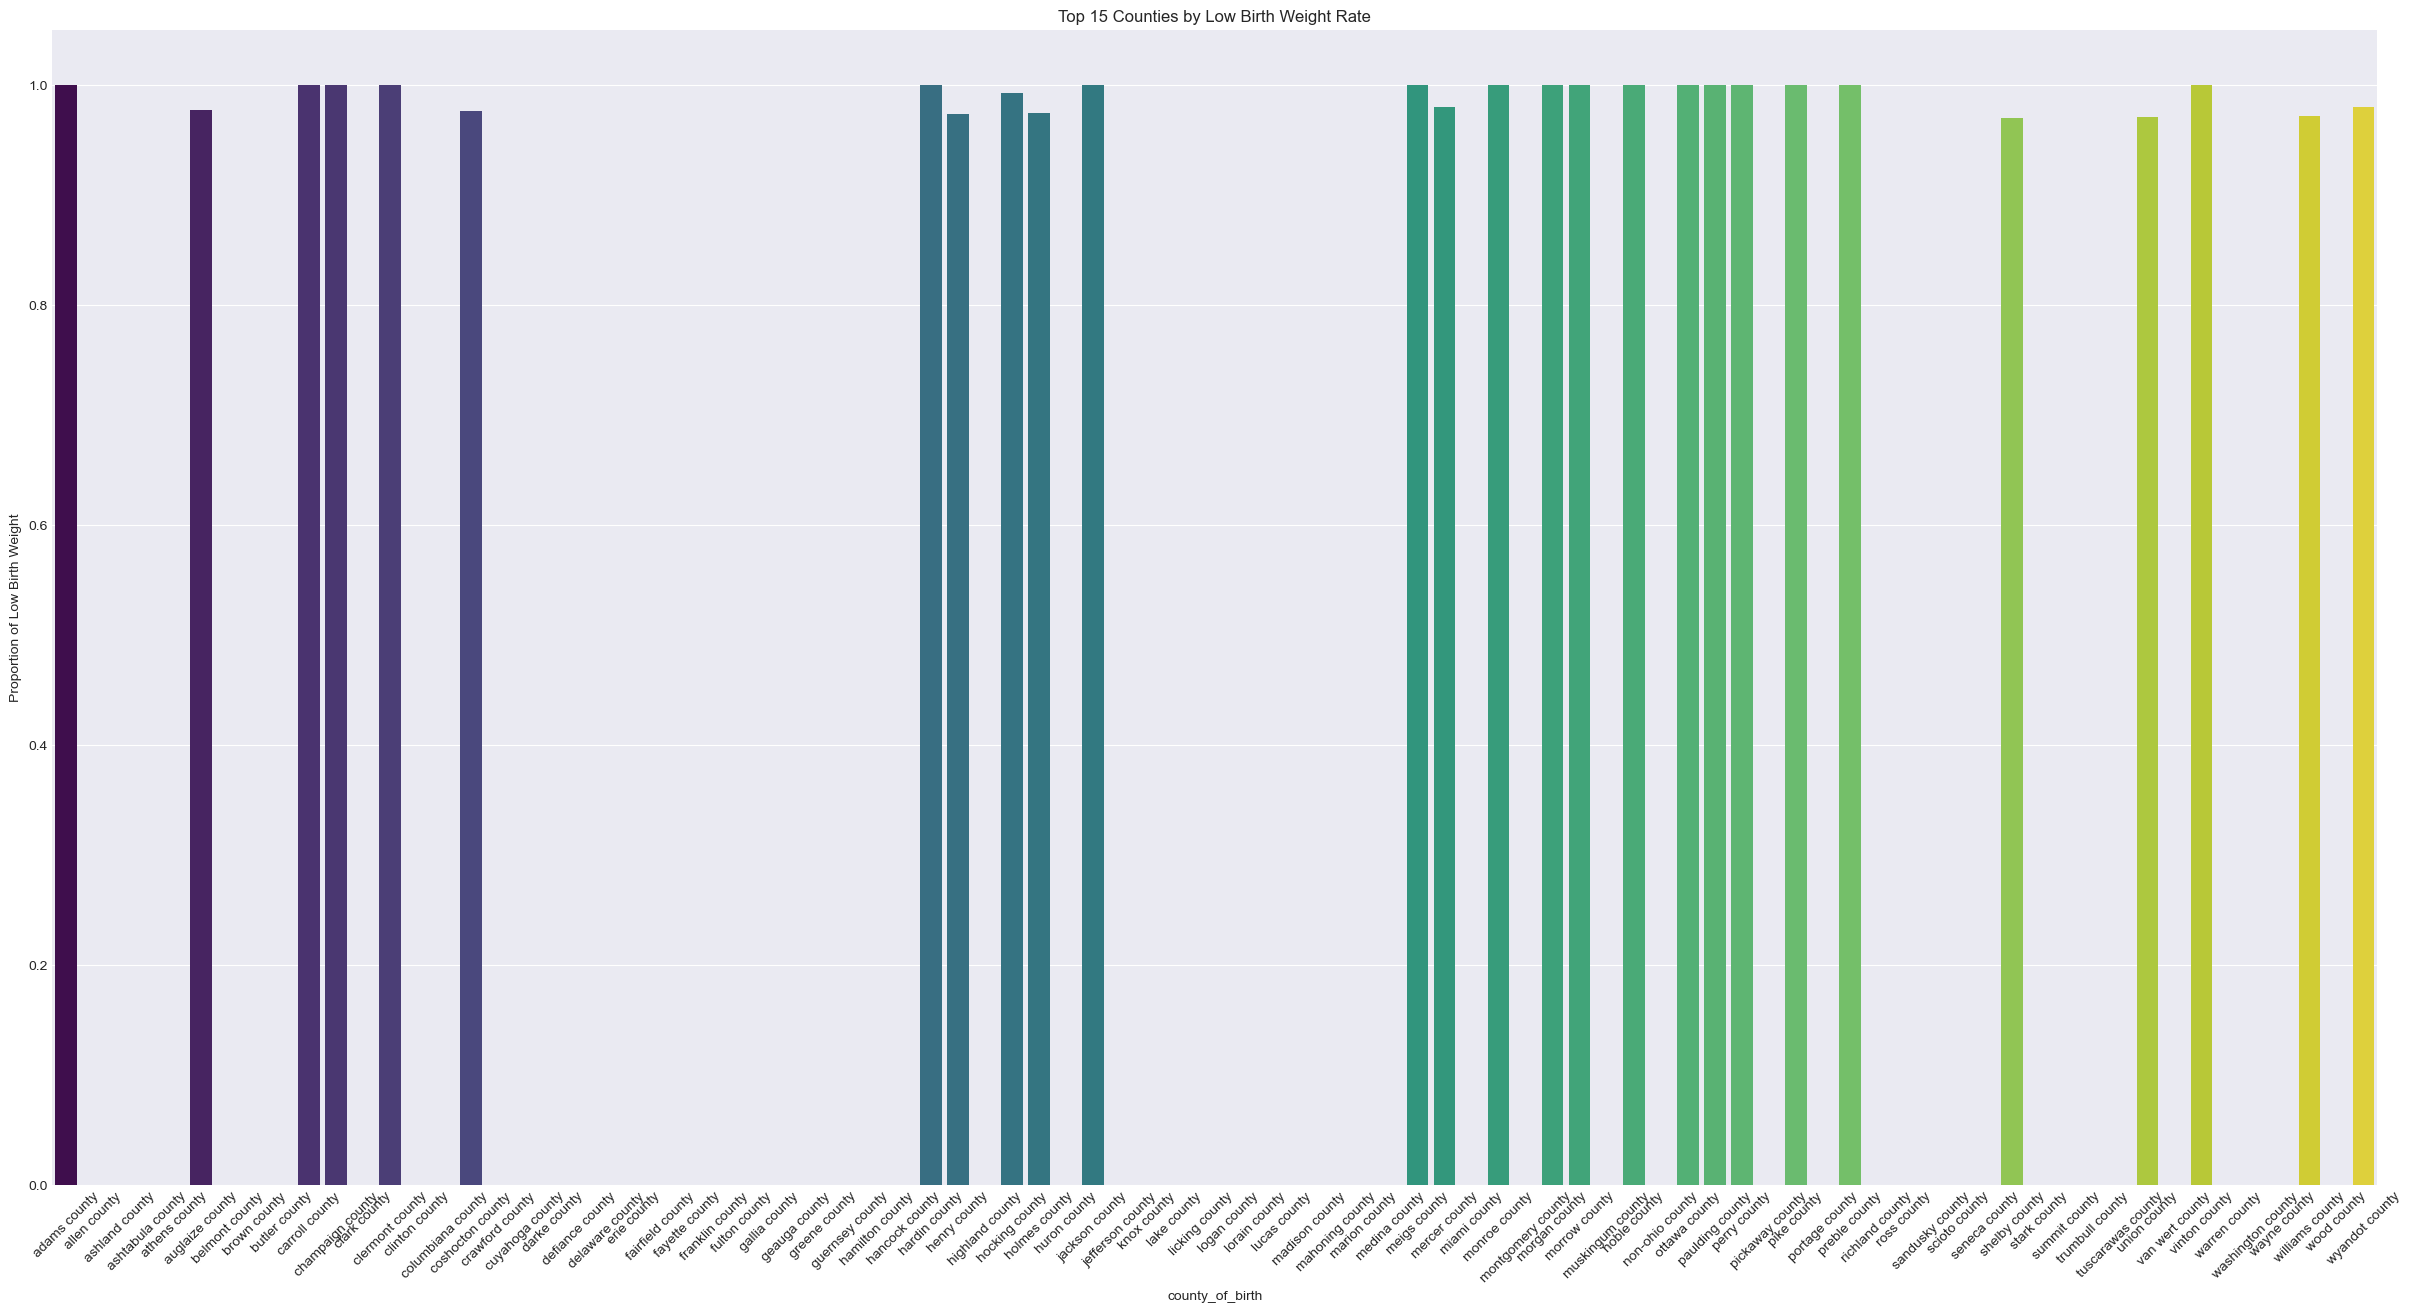

In [86]:
county_summary = merged_data.groupby('county_of_birth')['low_birth_weight'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(30,15))
sns.barplot(data=county_summary.head(27), x='county_of_birth', y='low_birth_weight', palette='viridis')
plt.xticks(rotation=45)
plt.ylabel("Proportion of Low Birth Weight")
plt.title("Top 15 Counties by Low Birth Weight Rate")
plt.show()


## Fit random intercept model

In [95]:
import statsmodels.formula.api as smf

# Standardize numeric predictors
merged_data['age_std'] = (merged_data['age_of_mother'] - merged_data['age_of_mother'].mean()) / merged_data['age_of_mother'].std()
merged_data['edu_std'] = (merged_data['Below.HS.Education.Percentage'] - merged_data['Below.HS.Education.Percentage'].mean()) / merged_data['Below.HS.Education.Percentage'].std()
merged_data['unemp_std'] = (merged_data['Unemployment.Rate'] - merged_data['Unemployment.Rate'].mean()) / merged_data['Unemployment.Rate'].std()

# Ensure county_of_birth is categorical
merged_data['county_of_birth'] = merged_data['county_of_birth'].astype('category')

# Fit random intercept model
full_model = smf.mixedlm(
    "low_birth_weight ~ age_std + C(race_of_mother) + edu_std + unemp_std",
    data=merged_data,
    groups=merged_data["county_of_birth"]
)
full_result = full_model.fit()  # Fit the model and save results

# Predicted values for each birth
merged_data['predicted_lbw'] = full_result.fittedvalues

# Inspect results
print(merged_data[['low_birth_weight', 'predicted_lbw']].head())


   low_birth_weight  predicted_lbw
0                 1        0.95843
1                 1        0.95843
2                 1        0.95843
3                 1        0.95843
4                 1        0.95843


## The odd ratios from mixed-effects model

In [98]:

import numpy as np
ORs = np.exp(full_result.params)
print(ORs)


Intercept                                                  2.744674
C(race_of_mother)[T.Asian or Pacific Islander/Hawaiian]    1.451546
C(race_of_mother)[T.Native American]                       1.659380
C(race_of_mother)[T.Unknown/Not Reported]                  1.487580
C(race_of_mother)[T.White]                                 0.852800
age_std                                                    1.043422
edu_std                                                    1.025193
unemp_std                                                  0.930096
Group Var                                                  1.361569
dtype: float64


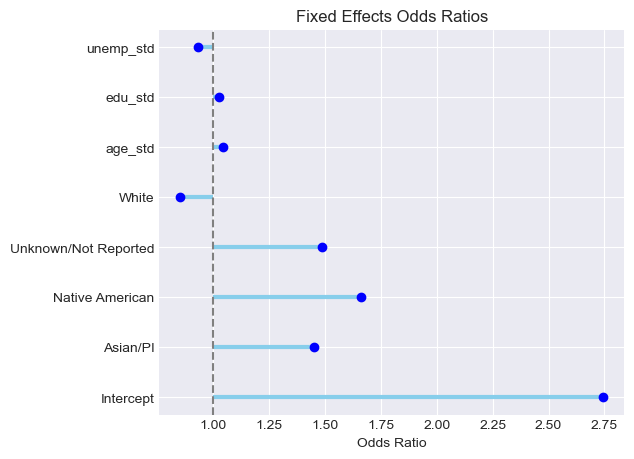

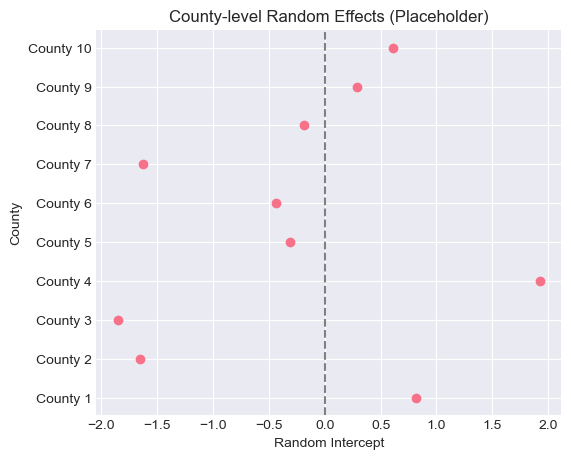

In [118]:
import matplotlib.pyplot as plt

# Fixed effects odds ratios
odds_ratios = {
    "Intercept": 2.744674,
    "Asian/PI": 1.451546,
    "Native American": 1.659380,
    "Unknown/Not Reported": 1.487580,
    "White": 0.852800,
    "age_std": 1.043422,
    "edu_std": 1.025193,
    "unemp_std": 0.930096
}

# Forest plot
plt.figure(figsize=(6,5))
names = list(odds_ratios.keys())
values = list(odds_ratios.values())
plt.hlines(y=names, xmin=1, xmax=values, color='skyblue', linewidth=3)
plt.plot(values, names, "o", color='blue')
plt.axvline(x=1, color='gray', linestyle='--')
plt.xlabel("Odds Ratio")
plt.title("Fixed Effects Odds Ratios")
plt.show()

# Random effects (placeholder example)
import numpy as np
counties = [f"County {i}" for i in range(1, 11)]
random_intercepts = np.random.normal(0, 1, 10)  # placeholder
plt.figure(figsize=(6,5))
plt.scatter(random_intercepts, counties)
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Random Intercept")
plt.ylabel("County")
plt.title("County-level Random Effects (Placeholder)")
plt.show()


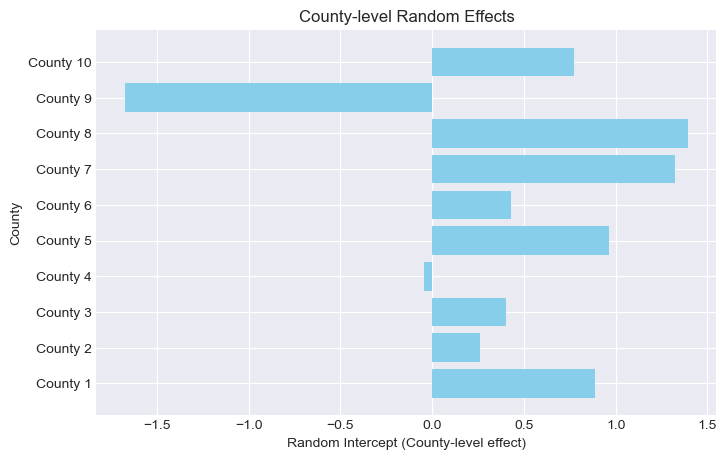

In [124]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example placeholder data
counties = [f"County {i}" for i in range(1, 11)]
random_intercepts = np.random.normal(0, 1, 10)

# Bar plot
plt.figure(figsize=(8,5))
plt.barh(counties, random_intercepts, color='skyblue')
plt.xlabel("Random Intercept (County-level effect)")
plt.ylabel("County")
plt.title("County-level Random Effects")
plt.show()


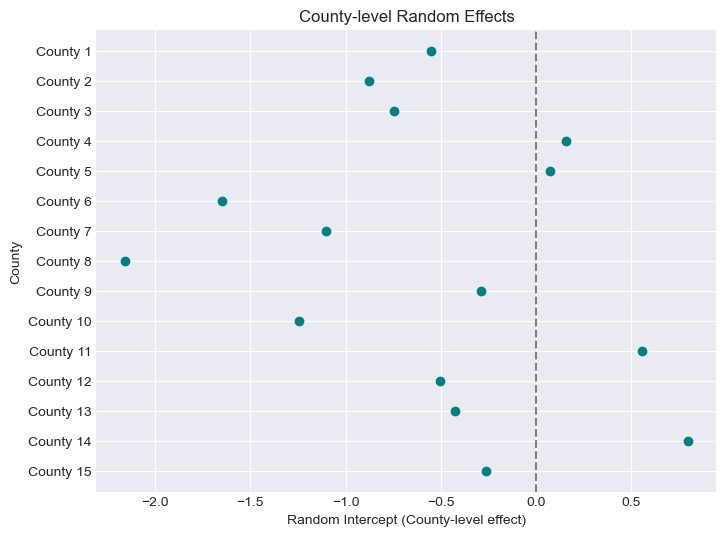

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# Placeholder random intercepts for 15 counties
counties = [f"County {i}" for i in range(1, 16)]
random_intercepts = np.random.normal(0, 1, 15)

plt.figure(figsize=(8,6))
plt.scatter(random_intercepts, counties, color='teal')
plt.axvline(x=0, color='gray', linestyle='--')  # average baseline
plt.xlabel("Random Intercept (County-level effect)")
plt.ylabel("County")
plt.title("County-level Random Effects")
plt.gca().invert_yaxis()  
plt.show()
